# RLE (run-length encodin)

A codificação RLE é eficaz quando nossos dados consistem em longas sequências de repetição de valores repetidos. É o caso do exemplo que veremos aqui: uma imagem de computador, no caso uma tela do jogo Mário Bros.

![mario bros](imgs/Mario_Bros.png)

Leia mais sobre RLE em :
- https://en.wikipedia.org/wiki/Run-length_encoding 
- Salomon and Motta, *Handbook of Data Compression*, Springer
- https://www.fileformat.info/mirror/egff/ch09_03.htm

Para simplificar o problema iremos tratar de imagem em tons de cinza, mas o mesmo princípio se aplica para imagens coloridas, ou outros tipos de dados. 

Vamos obter a imagem do site da Wikimedia, convertê-la para uma imagem em tons de cinza e salvá-la no formato PNM (Portable Anymap Utilities) ASCII (P2) e binário (P5).

Leia mais sobre os formatos PBM, PGM, PNM, e PPM no seguinte síto:
https://www.fileformat.info/format/pbm/egff.htm

Após salvar as imagens, abra os arquivos em um bloco de notas para verificar seu conteúdo.

In [1]:
system('wget -q https://upload.wikimedia.org/wikipedia/en/5/50/NES_Super_Mario_Bros.png -O /tmp/Mario_Bros.png');
system('convert /tmp/Mario_Bros.png -grayscale rec709luma -set colorspace Gray -compress none /tmp/Mario_Bros_ascii.pnm');
system('convert /tmp/Mario_Bros.png -grayscale rec709luma -set colorspace Gray /tmp/Mario_Bros_raw.pnm');

Vamos propor aqui o nosso próprio formato, uma variação do PNM com codificação RLE. Utilizaremos para tanto as funções *rleenco* e *rledeco* do pacote *communications*. Iremos varrer a imagem coluna por coluna, convertendo em um vetor unidimensional. Aplicaremos o codificação RLE a esta imagem unidimensional. Iremos salvar em um arquivo .prm com cabeçalho semelhante ao cabeçalho do PNM, a única diferença é a primeira linha que indica como os valores foram salvos: ASCII (R3) ou binário (R6).

Criaremos então duas funções: *image2prm* (converter imagem em um arquivo .prm) e *prm2image* (ler o arquivo .prm e retornar uma imagem).

In [2]:
function image2prm (X, magval, outname)
  if !strcmp(magval,'R3') && !strcmp(magval,'R6'), error('MagicValue must be R3 (ASCII) or R6 (Binary).'); endif
  sX = size(X);
  x = rleenco (X(:));
  maxVal = max(X(:));
  fid = fopen(outname, 'w');
  fprintf(fid,'%s\n',magval); % magic value
  fprintf(fid,'# created by LEo\n'); % comment
  fprintf(fid,'%d %d\n',sX); % dimensions
  fprintf(fid,'%d\n',maxVal);
  if strcmp(magval,'R3'), % ASCII
    fprintf(fid,'%d ',x(:));
  else, % Binary
            id = find (x > 255);
  for i = length(id):-1:1,
    do,
      x(id(i))-=255;
      x = [x(1:id(i)+1), 255, x(id(i)+1), x(id(i)+2:end)];
      until x(id(i)) <= 255;
   endfor
   fwrite(fid,x,'uint8');
  endif
  fclose(fid);
endfunction

Os valores de pixel estão no intervalo [0,255], podendo ser representados por um byte (uint8). Entretanto, o número de repetição dos pixels poderá eventualmente ser maior do que 255. Nesse caso, iremos quebrar a repetição. Por exemplo, se encontrarmos 300 repetições do valor 64, iremos converter em 255 repetições de 64 seguida de 45 repetições de 64. Desta forma poderemos salvar os números de repetições utilizando um único byte, assim como fazemos para os valores de pixel.

In [3]:
function X = prm2image (filename)
  fid = fopen (filename, 'r');
  magval = fgetl (fid);
  if !strcmp(magval,'R3') && !strcmp(magval,'R6'), error('Unknown format.'); endif
  do,
    line = fgetl (fid);
  until !strcmp(line(1),'#'),
  sX = str2num(line);
  maxVal = str2num( fgetl (fid) );
  if strcmp(magval,'R3'), % ASCII
    x = fscanf(fid, '%d');
  else, % Binary
    x = fread (fid, Inf, 'uint8');
  endif
  X = rledeco (x);
  X = reshape(X, sX);
  X = uint8(X);
  fclose (fid);
endfunction

Vamos agora verificar a funcionalida destas funções e compara os tamanhos dos aquivos gerados com aqueles codificados em PNM.

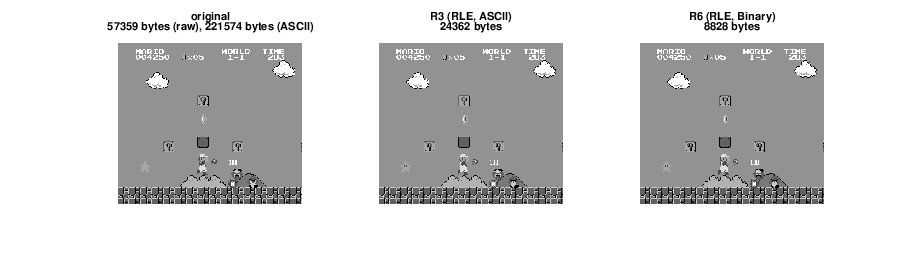

In [4]:
pkg load communications
% R3 (ASCII), R6 (Binary)
X = imread ('/tmp/Mario_Bros_raw.pnm');
s = dir('/tmp/Mario_Bros_raw.pnm');
Xrawsize = s.bytes;
s = dir('/tmp/Mario_Bros_ascii.pnm');
Xasciisize = s.bytes;
image2prm (X, 'R3', '/tmp/Mario_Bros_raw.prm');
image2prm (X, 'R6', '/tmp/Mario_Bros_ascii.prm');
Y1 = prm2image('/tmp/Mario_Bros_raw.prm');
s = dir('/tmp/Mario_Bros_raw.prm');
Y1size = s.bytes;
Y2 = prm2image('/tmp/Mario_Bros_ascii.prm');
s = dir('/tmp/Mario_Bros_ascii.prm');
Y2size = s.bytes;
figure("position",get(0,"screensize")./[1 1 1.5 3])
subplot(1,3,1); imshow (X); title (sprintf('original\n%d bytes (raw), %d bytes (ASCII)',Xrawsize,Xasciisize));
subplot(1,3,2); imshow (Y1); title (sprintf('R3 (RLE, ASCII)\n%d bytes',Y1size));
subplot(1,3,3); imshow (Y2); title (sprintf('R6 (RLE, Binary)\n%d bytes',Y2size));